In [1]:
!pip install -U transformers==4.43.4 tokenizers==0.19.1 --no-deps --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 89.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from transformers import AutoModel, AutoTokenizer

from PIL import Image
from tqdm import tqdm
import shutil, time, json, os

In [3]:
captions = pd.read_csv("/kaggle/input/flickr30k/captions.txt", sep=',')[['image_name', 'comment']]
captions.head()

,image_name,comment
0,1000092795.jpg,Two young guys with shaggy hair look at their ...
1,1000092795.jpg,Two young White males are outside near many b...
2,1000092795.jpg,Two men in green shirts are standing in a yard .
3,1000092795.jpg,A man in a blue shirt standing in a garden .
4,1000092795.jpg,Two friends enjoy time spent together .


## 1. Data splitting

In [4]:
split_file_path = "/kaggle/input/karpathy-split-flickr30k/dataset_flickr30k.json"

with open(split_file_path, 'r') as f:
    split_data = json.load(f)
    
train_ids = []
val_ids = []
test_ids = []

for img in split_data['images']:
    if img['split'] == 'train':
        train_ids.append(img['filename'])
    elif img['split'] == 'val':
        val_ids.append(img['filename'])
    elif img['split'] == 'test':
        test_ids.append(img['filename'])

print(f"Karpathy defined {len(train_ids)} train images")
print(f"Karpathy defined {len(val_ids)} val images")
print(f"Karpathy defined {len(test_ids)} test images")

train_df = captions[captions['image_name'].isin(train_ids)]
val_df = captions[captions['image_name'].isin(val_ids)]
test_df = captions[captions['image_name'].isin(test_ids)]

print("\n--- Final DataFrame Sizes ---")
print(f"Train DF: {len(train_df)} rows")
print(f"Val DF:   {len(val_df)} rows")
print(f"Test DF:  {len(test_df)} rows")

Karpathy defined 29000 train images
Karpathy defined 1014 val images
Karpathy defined 1000 test images

--- Final DataFrame Sizes ---
Train DF: 145000 rows
Val DF:   5070 rows
Test DF:  5000 rows


## 2. Quick EDA

0    83
1    53
2    48
3    44
4    39
Name: comment_length, dtype: int64
--------------------------------------------------
count    145000.000000
mean         64.144207
std          26.670841
min           7.000000
25%          46.000000
50%          59.000000
75%          76.000000
max         403.000000
Name: comment_length, dtype: float64


/tmp/ipykernel_19/1777625282.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['comment_length'] = train_df['comment'].apply(calculate_comment_length)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


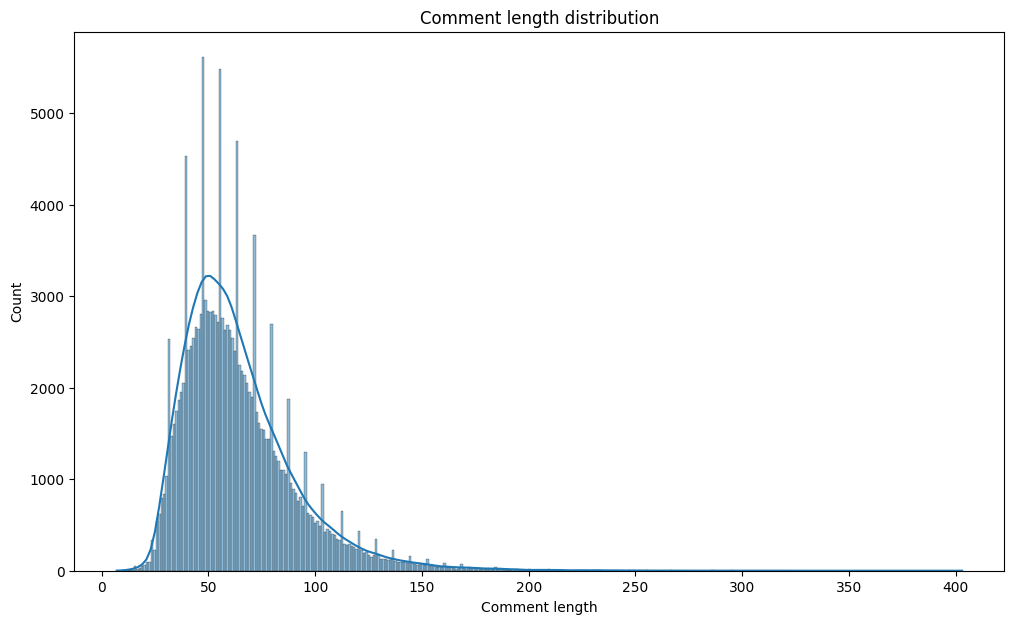

In [5]:
def calculate_comment_length(comment):
    return len(comment)

train_df['comment_length'] = train_df['comment'].apply(calculate_comment_length)
print(train_df['comment_length'].head())
print("-"*50)
print(train_df['comment_length'].describe())

plt.figure(figsize=(12, 7))
sns.histplot(train_df['comment_length'], kde=True)
plt.xlabel("Comment length")
plt.title("Comment length distribution")
plt.show()

The plot is right skewed. In order to find the sweet spot of getting the minimum length of comment while also getting the most information out of it, we use this rule-of-thumb formula:

> mean + 1 * std = $64 + 26.6 \approx 90.6$ (This usually covers ~84% of the data)
>
> mean + 2 * std = $64 + (2 \times 26.6) \approx 117.3$ (This usually covers ~97.7% of the data)

Since we use MiniLM, and the most computationally efficient sequence lengths for the model are powers of 2 (or multiples of 32/64), we will use 128 as it will cover ~98% of the data.

## 3. Dataset wrapper building

In [6]:
class Flickr30k_Dataset(Dataset):
    def __init__(self, image_root, captions_df, tokenizer, transform=None):
        self.image_root = image_root
        self.captions = self._load_captions(captions_df)
        self.tokenizer = tokenizer
        self.transform = transform
        
    def _load_captions(self, captions_df):
        data = []
        for row in captions_df.itertuples(index=False):
            image_name = row.image_name
            caption = row.comment
            image_path = os.path.join(self.image_root, image_name)
            data.append((image_path, caption))
        return data

    def __getitem__(self, idx):
        image_path, caption = self.captions[idx]
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        text_inputs = self.tokenizer(
            caption,
            padding = "max_length",
            truncation = True,
            max_length = 128,
            return_tensors = "pt"
        )

        return image, text_inputs['input_ids'].squeeze(0), text_inputs['attention_mask'].squeeze(0)

    def __len__(self):
        return len(self.captions)

## 4. Multi-Modal Model building

### 4.1 Image model encoder

In [7]:
class ImageEncoder(nn.Module):
    def __init__(self, embed_dim=256):
        super(ImageEncoder, self).__init__()
        resnet = models.efficientnet_b0(pretrained=True)
    
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)

        for param in self.resnet.parameters():
            param.requires_grad = False

        for param in self.resnet[0][7].parameters():
            param.requires_grad = True

        self.dropout = nn.Dropout(p=0.5)
        
        self.fc = nn.Linear(1280, embed_dim)

    def forward(self, images):
        features = self.resnet(images) # (Batch, 512, 1, 1)
        features = features.view(features.size(0), -1) # flatten to (Batch, 512)
        features = self.dropout(features)
        embeddings = self.fc(features) # project to (Batch, embed_dim)
        embeddings = F.normalize(embeddings, dim=-1)
        return embeddings

### 4.2 Text model encoder

In [8]:
class TextEncoder(nn.Module):
    def __init__(self, embed_dim=256):
        super(TextEncoder, self).__init__()
        self.transformer = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L12-v2")

        for param in self.transformer.parameters():
            param.requires_grad = False

        for param in self.transformer.encoder.layer[11].parameters():
            param.requires_grad = True

        hidden_size = self.transformer.config.hidden_size
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(hidden_size, embed_dim)

    def forward(self, input_ids, attention_mask):
        outputs = self.transformer(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        # text_features = outputs.last_hidden_state[:, 0, :] # CLS token
        token_embeddings = outputs.last_hidden_state
        
        expanded_mask = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        masked_embeddings = token_embeddings * expanded_mask
        sum_embeddings = torch.sum(masked_embeddings, 1)
        sum_mask = torch.sum(expanded_mask, 1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_pooled_features = sum_embeddings / sum_mask
        mean_pooled_features = self.dropout(mean_pooled_features)
        
        # embeddings = self.fc(text_features)
        embeddings = self.fc(mean_pooled_features)
        embeddings = F.normalize(embeddings, dim=-1)
        return embeddings

### 4.3 Combining both encoders

In [9]:
class CrossModalModel(nn.Module):
    def __init__(self, embed_dim=512):
        super(CrossModalModel, self).__init__()
        self.image_encoder = ImageEncoder(embed_dim)
        self.text_encoder = TextEncoder(embed_dim)

        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1/0.07))

    def forward(self, images, input_ids, attention_mask):
        image_embeds = self.image_encoder(images)
        text_embeds = self.text_encoder(input_ids, attention_mask)
        return image_embeds, text_embeds

### 5. Loss function

In [10]:
def clip_loss(image_embeds, text_embeds, logit_scale):
    """
    temperature: Controls how sharply the model distinguishes pairs (lower → sharper).
    """
    # Normalize (should already be normalized, but for safety)
    # image_embeds = nn.functional.normalize(image_embeds, dim=-1)
    # text_embeds = nn.functional.normalize(text_embeds, dim=-1)
    
    # Compute similarity matrix (batch_size x batch_size)
    # logits = image_embeds @ text_embeds.t() / temperature # cosine_similarity/temperature

    scale = logit_scale.exp()
    logits = (image_embeds @ text_embeds.t()) * scale

    # Targets: correct pairs are along the diagonal
    labels = torch.arange(len(logits)).to(logits.device)

    # Cross-entropy loss both ways (image→text and text→image)
    loss_image_text = F.cross_entropy(logits, labels)
    loss_text_image = F.cross_entropy(logits.t(), labels)

    # Final loss is average
    return (loss_image_text + loss_text_image) / 2

## 6. Data augmentation & preperation

In [11]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

In [12]:
IMG_ROOT = "/kaggle/input/flickr30k/flickr30k_images"
TOKENIZER_NAME = "sentence-transformers/all-MiniLM-L12-v2"

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)

train_dataset = Flickr30k_Dataset(
    image_root=IMG_ROOT, 
    captions_df=train_df, 
    tokenizer=tokenizer,
    transform=train_transform
)
val_dataset = Flickr30k_Dataset(
    image_root=IMG_ROOT, 
    captions_df=val_df, 
    tokenizer=tokenizer, 
    transform=val_test_transform
)
test_dataset = Flickr30k_Dataset(
    image_root=IMG_ROOT, 
    captions_df=test_df,
    tokenizer=tokenizer, 
    transform=val_test_transform
)


train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

## 7. Optimizer & model training

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CrossModalModel(embed_dim=512).to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 125MB/s] 


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

In [14]:
EPOCHS = 5

def train_model(model, train_loader, val_loader, epochs, optimizer, loss_fn, device):
    save_path = "/kaggle/working/checkpoints"
    os.makedirs(save_path, exist_ok=True)
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0

        train_progress_bar = tqdm(
            train_loader, 
            desc=f"Epoch [{epoch+1}/{epochs}] Training", 
            leave=False
        )

        for i, (images, input_ids, attention_mask) in enumerate(train_progress_bar):
            images = images.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            optimizer.zero_grad()
            img_embeds, txt_embeds = model(images, input_ids, attention_mask)
            loss = loss_fn(img_embeds, txt_embeds, model.logit_scale)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                model.logit_scale.clamp_(0, np.log(100))

            total_train_loss += loss.item()
            
            running_avg_loss = total_train_loss / (i + 1)
            train_progress_bar.set_postfix(train_loss=f"{running_avg_loss:.4f}")
        
        avg_train_loss = total_train_loss / len(train_loader)

        model.eval()
        total_val_loss = 0.0
        all_img_embeds, all_txt_embeds = [], []
        
        with torch.no_grad():
            val_progress_bar = tqdm(
                val_loader,
                desc=f"Epoch [{epoch+1}/{epochs}] Validation",
                leave=False
            )
            
            for i, (images, input_ids, attention_mask) in enumerate(val_progress_bar):
                images = images.to(device)
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)

                img_embeds, txt_embeds = model(images, input_ids, attention_mask)
                loss = loss_fn(img_embeds, txt_embeds, model.logit_scale)
                total_val_loss += loss.item()

                all_img_embeds.append(img_embeds.cpu())
                all_txt_embeds.append(txt_embeds.cpu())
                
                running_avg_val_loss = total_val_loss / (i + 1)
                val_progress_bar.set_postfix(val_loss=f"{running_avg_val_loss:.4f}")

        avg_val_loss = total_val_loss / len(val_loader)
        
        print(f"Epoch [{epoch+1}/{epochs}] -> Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        model_save_path = os.path.join(save_path, f"model_epoch_{epoch+1}.pt")
        torch.save(model.state_dict(), model_save_path)

        img_embeds_tensor = torch.cat(all_img_embeds, dim=0)
        txt_embeds_tensor = torch.cat(all_txt_embeds, dim=0)
        torch.save(img_embeds_tensor, os.path.join(save_path, f"img_embeds_epoch_{epoch+1}.pt"))
        torch.save(txt_embeds_tensor, os.path.join(save_path, f"txt_embeds_epoch_{epoch+1}.pt"))

    timestamp = time.strftime("%Y%m%d_%H%M%S")
    shutil.make_archive(f"/kaggle/working/checkpoints_{timestamp}", 'zip', save_path)
    print(f"Zipped checkpoints_{timestamp}.zip for download")

In [15]:
train_model(model, train_loader, val_loader, EPOCHS, optimizer, clip_loss, device)

Epoch [1/5] -> Train Loss: 2.2678 | Val Loss: 2.4296


Epoch [2/5] -> Train Loss: 1.7076 | Val Loss: 2.3588


Epoch [3/5] -> Train Loss: 1.5316 | Val Loss: 2.3338


Epoch [4/5] -> Train Loss: 1.4143 | Val Loss: 2.3195


Epoch [5/5] -> Train Loss: 1.3342 | Val Loss: 2.3080
Zipped checkpoints_20251030_040653.zip for download


## 8. Model evaluation

Similarity matrix shape: torch.Size([64, 64])


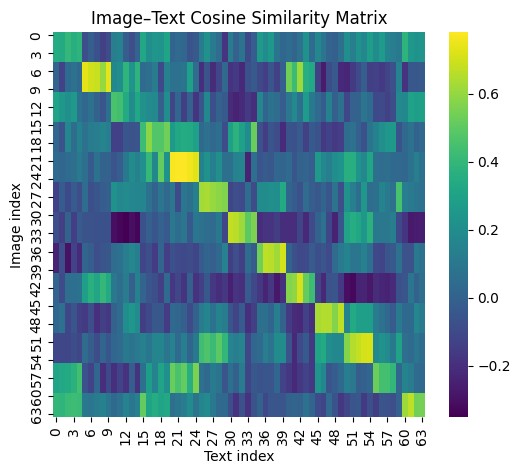

In [16]:
model.eval()

images, input_ids, attention_mask = next(iter(val_loader))
images = images.to(device)
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)

with torch.no_grad():
    img_embeds, txt_embeds = model(images, input_ids, attention_mask)

# shape: (batch_size, batch_size)
sim_matrix = torch.matmul(img_embeds, txt_embeds.T)

print("Similarity matrix shape:", sim_matrix.shape)

sim_np = sim_matrix.cpu().numpy()

plt.figure(figsize=(6,5))
sns.heatmap(sim_np, annot=False, cmap="viridis")
plt.title("Image–Text Cosine Similarity Matrix")
plt.xlabel("Text index")
plt.ylabel("Image index")
plt.show()